# DR Detection from ODIR-5K Dataset Using Transfer Learning: Freeze: 50% - 100 - 8

## 1. Imports and Setup

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import timm
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def setup_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    return device

device = setup_device()

Device: cuda
GPU: Tesla P100-PCIE-16GB


## 2. Configuration

In [ ]:
CONFIG = {
    'DATA_DIR': '/kaggle/input/odir-dataset/ODIR_Data',
    'SAVE_DIR': '/kaggle/working',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'NUM_EPOCHS': 100,
    'LEARNING_RATE': 3e-4,
    'WEIGHT_DECAY': 1e-3,
    'FREEZE_PCT': 0.5,
    'NUM_WORKERS': 0,
    'EARLY_STOPPING_PATIENCE': 8,
    'LR_PATIENCE': 5,
    'LR_FACTOR': 0.5,
}

os.makedirs(CONFIG['SAVE_DIR'], exist_ok=True)
print("Configuration loaded successfully")

Configuration loaded successfully


## 3. Data Extraction

In [ ]:
def extract_data_from_npz(data_dir):

    data = {'train': [], 'val': [], 'test': []}

    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_dir, split)
        if not os.path.exists(split_path):
            continue

        files = sorted([f for f in os.listdir(split_path) if f.endswith('.npz')])

        for file in files:
            try:
                npz_data = np.load(os.path.join(split_path, file))

                image = npz_data['slo_fundus']
                label = int(npz_data['dr_class'])
                gender = int(npz_data['male']) if 'male' in npz_data.files else -1

                eye = 'left' if '_left' in file.lower() else 'right'

                data[split].append({
                    'image': image,
                    'label': label,
                    'gender': gender,
                    'eye': eye,
                    'filename': file
                })

            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue

    return data

print("Extracting data from .npz files...")
data_dict = extract_data_from_npz(CONFIG['DATA_DIR'])

for split in ['train', 'val', 'test']:
    print(f"{split}: {len(data_dict[split])} samples")


Extracting data from .npz files...
train: 4476 samples
val: 641 samples
test: 1914 samples


## 4. Class Analysis

In [ ]:
def analyze_classes(data_dict):

    all_labels = []
    for split in data_dict.values():
        all_labels.extend([s['label'] for s in split])

    unique_classes = sorted(list(set(all_labels)))
    num_classes = len(unique_classes)

    print(f"\nUnique classes: {unique_classes}")
    print(f"Number of classes: {num_classes}")

    label_counts = pd.Series(all_labels).value_counts().sort_index()
    print("\nClass distribution:")
    for cls, count in label_counts.items():
        print(f"  Class {cls}: {count} ({count/len(all_labels)*100:.1f}%)")

    return unique_classes, num_classes

unique_classes, num_classes = analyze_classes(data_dict)


Unique classes: [0, 1]
Number of classes: 2

Class distribution:
  Class 0: 5240 (74.5%)
  Class 1: 1791 (25.5%)


## 5. Statistical Visualization

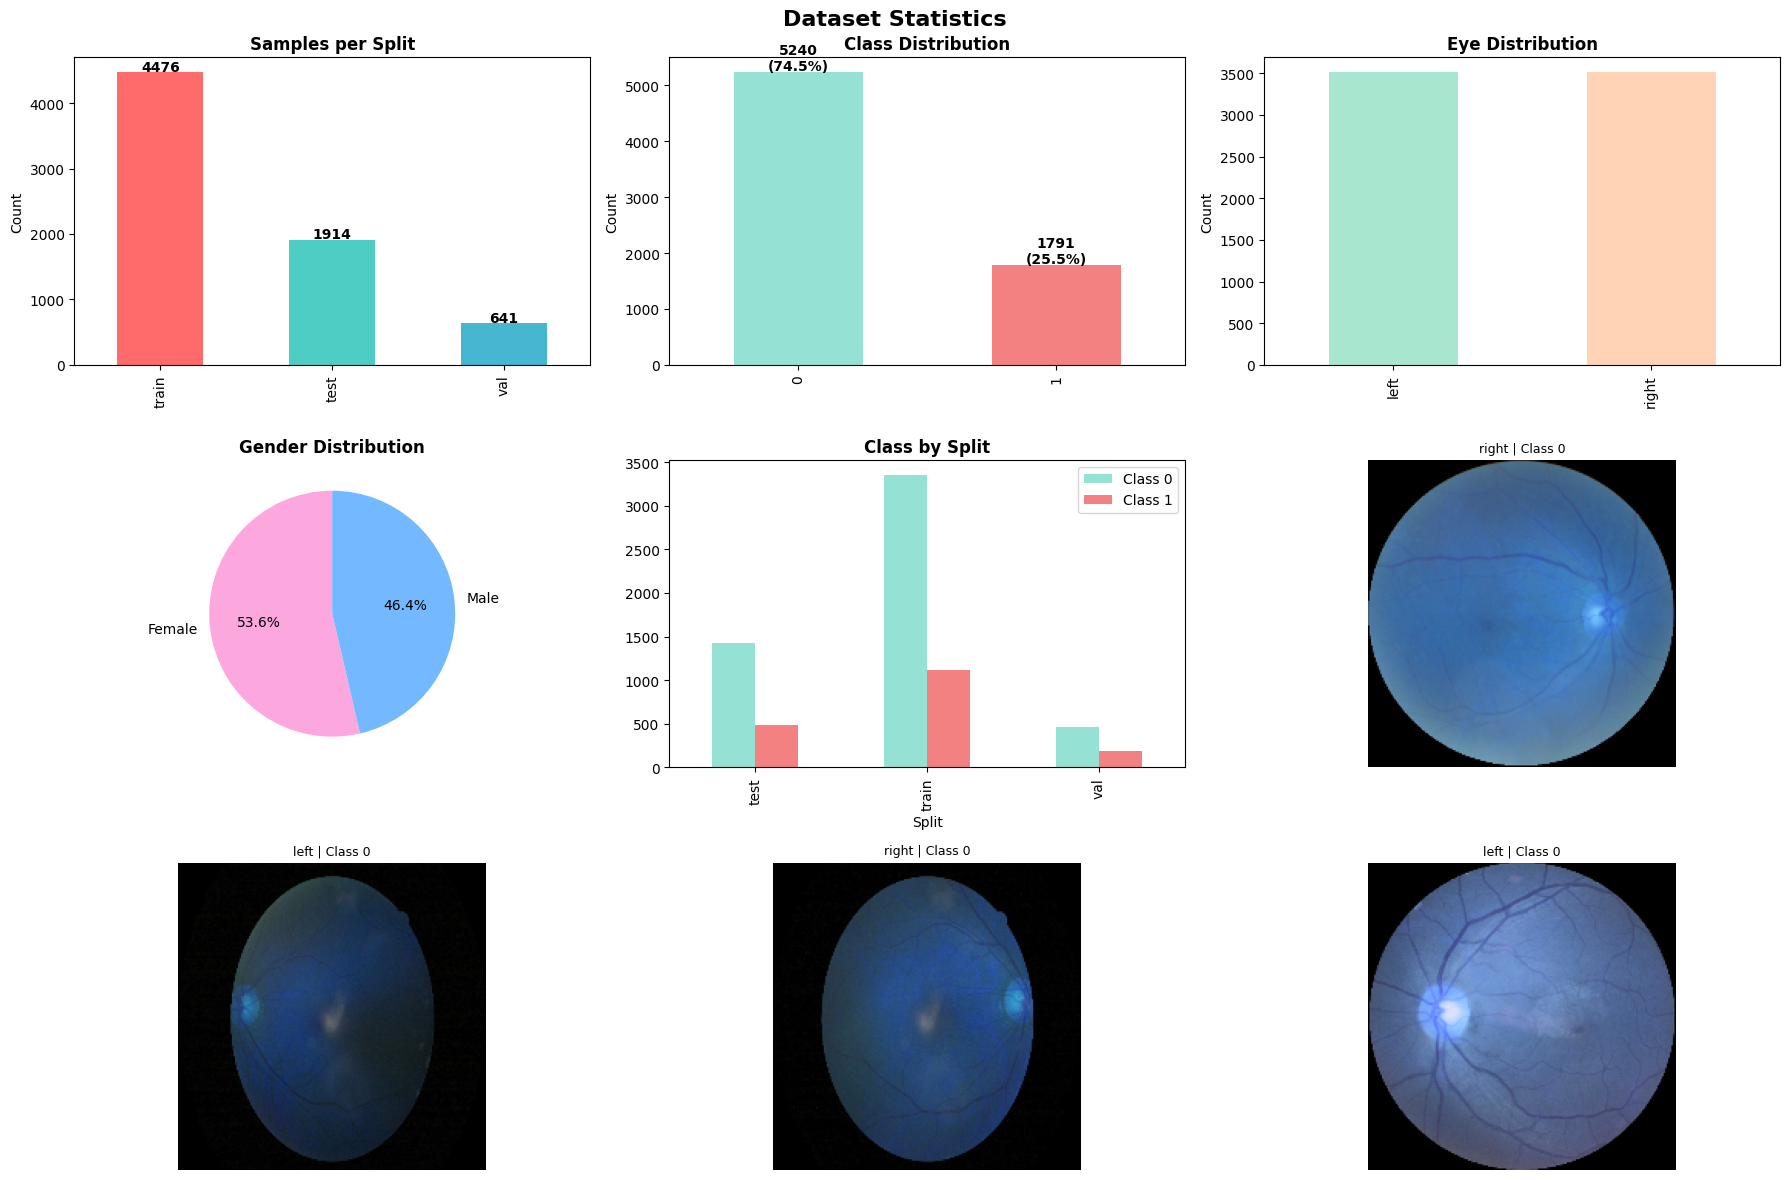

In [ ]:
def plot_dataset_statistics(data_dict, save_dir):

    fig = plt.figure(figsize=(18, 12))

    # Collect statistics
    all_labels, all_genders, all_eyes, all_splits = [], [], [], []
    for split_name, samples in data_dict.items():
        for sample in samples:
            all_labels.append(sample['label'])
            all_genders.append(sample['gender'])
            all_eyes.append(sample['eye'])
            all_splits.append(split_name)

    # 1. Samples per split
    ax1 = plt.subplot(3, 3, 1)
    split_counts = pd.Series(all_splits).value_counts()
    split_counts.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title('Samples per Split', fontweight='bold')
    ax1.set_ylabel('Count')
    for i, v in enumerate(split_counts):
        ax1.text(i, v+20, str(v), ha='center', fontweight='bold')

    # 2. Class distribution
    ax2 = plt.subplot(3, 3, 2)
    label_counts = pd.Series(all_labels).value_counts().sort_index()
    label_counts.plot(kind='bar', ax=ax2, color=['#95E1D3', '#F38181'])
    ax2.set_title('Class Distribution', fontweight='bold')
    ax2.set_ylabel('Count')
    for i, v in enumerate(label_counts):
        ax2.text(i, v+30, f'{v}\n({v/len(all_labels)*100:.1f}%)', ha='center', fontweight='bold')

    # 3. Eye distribution
    ax3 = plt.subplot(3, 3, 3)
    eye_counts = pd.Series(all_eyes).value_counts()
    eye_counts.plot(kind='bar', ax=ax3, color=['#A8E6CF', '#FFD3B6'])
    ax3.set_title('Eye Distribution', fontweight='bold')
    ax3.set_ylabel('Count')

    # 4. Gender distribution
    ax4 = plt.subplot(3, 3, 4)
    gender_data = [g for g in all_genders if g != -1]
    if len(gender_data) > 0:
        gender_counts = pd.Series(gender_data).value_counts()
        ax4.pie(gender_counts, labels=['Female', 'Male'], autopct='%1.1f%%',
               colors=['#FDA7DF', '#74B9FF'], startangle=90)
        ax4.set_title('Gender Distribution', fontweight='bold')

    # 5. Class by split
    ax5 = plt.subplot(3, 3, 5)
    df = pd.DataFrame({'Split': all_splits, 'Label': all_labels})
    split_label = df.groupby(['Split', 'Label']).size().unstack(fill_value=0)
    split_label.plot(kind='bar', ax=ax5, color=['#95E1D3', '#F38181'])
    ax5.set_title('Class by Split', fontweight='bold')
    ax5.legend([f'Class {i}' for i in sorted(set(all_labels))])

    # 6. Sample images
    for idx in range(4):
        ax = plt.subplot(3, 3, 6+idx)
        if idx < len(data_dict['train']):
            sample = data_dict['train'][idx]
            img = sample['image']
            if img.max() > 1:
                img = img / 255.0
            ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
            ax.set_title(f"{sample['eye']} | Class {sample['label']}", fontsize=9)
            ax.axis('off')

    plt.suptitle('Dataset Statistics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'dataset_statistics.png'), dpi=150)
    plt.show()
    plt.close()




plot_dataset_statistics(data_dict, CONFIG['SAVE_DIR'])

## 6. Dataset Class

In [ ]:
class DRDataset(Dataset):

    """
    Dataset class for DR detection from fundus images
    """

    def __init__(self, data_list, transform=None):

        self.data = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = sample['image'].astype(np.float32)

        # Normalize to [0, 1]
        if image.max() > 1.0:
            image = image / 255.0

        # Convert to 3 channels
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=0)
        elif len(image.shape) == 3:
            if image.shape[2] == 3:
                image = np.transpose(image, (2, 0, 1))
            elif image.shape[0] != 3:
                image = np.stack([image[0], image[0], image[0]], axis=0)

        image = torch.FloatTensor(image)

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'label': sample['label'],
            'gender': sample['gender']
        }

## 7. Data Preprocessing and Loaders

In [ ]:
def create_transforms(img_size=224):

    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size), antialias=True),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.3),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size), antialias=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform


def create_dataloaders(data_dict, config, device):

    train_transform, val_transform = create_transforms(config['IMG_SIZE'])

    train_dataset = DRDataset(data_dict['train'], train_transform)
    val_dataset = DRDataset(data_dict['val'], val_transform)
    test_dataset = DRDataset(data_dict['test'], val_transform)

    # Handle class imbalance
    labels = [s['label'] for s in data_dict['train']]
    class_counts = np.bincount(labels)
    class_weights_array = 1.0 / class_counts
    sample_weights = [class_weights_array[label] for label in labels]

    train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    train_loader = DataLoader(
        train_dataset, batch_size=config['BATCH_SIZE'],
        sampler=train_sampler, num_workers=config['NUM_WORKERS']
    )
    val_loader = DataLoader(
        val_dataset, batch_size=config['BATCH_SIZE'],
        shuffle=False, num_workers=config['NUM_WORKERS']
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config['BATCH_SIZE'],
        shuffle=False, num_workers=config['NUM_WORKERS']
    )

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.FloatTensor(class_weights).to(device)



    return train_loader, val_loader, test_loader, class_weights

train_loader, val_loader, test_loader, class_weights = create_dataloaders(data_dict, CONFIG, device)

## 8. Model Architecture

In [ ]:
class TransferLearningModel(nn.Module):
    """
    Transfer learning model with configurable backbone
    """

    def __init__(self, model_name, num_classes, freeze_pct=0.5):

        super().__init__()

        if model_name == 'vgg16':
            self.backbone = models.vgg16(pretrained=True)
            num_features = self.backbone.classifier[6].in_features
            self.backbone.classifier[6] = nn.Linear(num_features, num_classes)
            params_to_freeze = list(self.backbone.features.parameters())

        elif model_name == 'resnet50':
            self.backbone = models.resnet50(pretrained=True)
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(num_features, num_classes)
            params_to_freeze = list(self.backbone.parameters())[:-2]

        elif model_name == 'densenet121':
            self.backbone = models.densenet121(pretrained=True)
            num_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(num_features, num_classes)
            params_to_freeze = list(self.backbone.features.parameters())

        elif model_name == 'efficientnet_b0':
            self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
            params_to_freeze = list(self.backbone.parameters())[:-2]

        elif model_name == 'vit_tiny':
            self.backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=num_classes)
            params_to_freeze = list(self.backbone.parameters())[:-2]

        # Freeze parameters
        num_freeze = int(len(params_to_freeze) * freeze_pct)
        for param in params_to_freeze[:num_freeze]:
            param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

## 9. Training Function

In [ ]:
def train_model(model, model_name, train_loader, val_loader, class_weights, config, device):

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=config['LEARNING_RATE'], weight_decay=config['WEIGHT_DECAY'])

    # ReduceLROnPlateau scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=config['LR_FACTOR'],
        patience=config['LR_PATIENCE'], verbose=True
    )

    history = {
        'train_loss': [], 'train_acc': [], 'train_auc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': []
    }

    best_val_acc = 0
    epochs_no_improve = 0
    best_path = os.path.join(config['SAVE_DIR'], f'{model_name}_best.pth')

    for epoch in range(config['NUM_EPOCHS']):
        # Train
        model.train()
        train_loss, train_preds, train_labels, train_probs = 0, [], [], []

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["NUM_EPOCHS"]}', leave=False):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            train_probs.extend(probs[:, 1].detach().cpu().numpy())
            train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds)
        train_auc = roc_auc_score(train_labels, train_probs) if len(np.unique(train_labels)) > 1 else 0

        # Validation
        model.eval()
        val_loss, val_preds, val_labels, val_probs = 0, [], [], []

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                probs = torch.softmax(outputs, dim=1)
                val_probs.extend(probs[:, 1].cpu().numpy())
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds)
        val_auc = roc_auc_score(val_labels, val_probs) if len(np.unique(val_labels)) > 1 else 0

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_auc'].append(train_auc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Update scheduler
        scheduler.step(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_path)
        else:
            epochs_no_improve += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, AUC={train_auc:.4f} | "
                  f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, AUC={val_auc:.4f} | "
                  f"No improve: {epochs_no_improve}")

        if epochs_no_improve >= config['EARLY_STOPPING_PATIENCE']:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return history, best_path

## 10. Evaluation Function

In [ ]:
def evaluate_model(model, test_loader, model_name, num_classes, device):

    model.eval()
    all_preds, all_labels, all_probs, all_genders = [], [], [], []

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_probs.extend(probs[:, 1].cpu().numpy())
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(batch['label'].numpy())
            all_genders.extend(batch['gender'].numpy())

    # Overall metrics
    acc = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Gender-specific AUC
    male_idx = [i for i, g in enumerate(all_genders) if g == 1]
    female_idx = [i for i, g in enumerate(all_genders) if g == 0]

    male_auc = roc_auc_score(
        [all_labels[i] for i in male_idx],
        [all_probs[i] for i in male_idx]
    ) if len(male_idx) > 0 and len(np.unique([all_labels[i] for i in male_idx])) > 1 else 0

    female_auc = roc_auc_score(
        [all_labels[i] for i in female_idx],
        [all_probs[i] for i in female_idx]
    ) if len(female_idx) > 0 and len(np.unique([all_labels[i] for i in female_idx])) > 1 else 0

    print(f"\n{'='*80}")
    print(f"{model_name} - Test Results")
    print(f"{'='*80}")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Male AUC: {male_auc:.4f} (n={len(male_idx)})")
    print(f"Female AUC: {female_auc:.4f} (n={len(female_idx)})")

    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f'Class_{i}' for i in range(num_classes)]))

    return {
        'accuracy': acc,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'male_auc': male_auc,
        'female_auc': female_auc
    }

## 11. Visualization Functions

In [ ]:
def plot_training_curves(history, model_name, save_dir):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch', fontweight='bold')
    axes[0].set_ylabel('Loss', fontweight='bold')
    axes[0].set_title(f'{model_name} - Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch', fontweight='bold')
    axes[1].set_ylabel('Accuracy', fontweight='bold')
    axes[1].set_title(f'{model_name} - Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # AUC
    axes[2].plot(epochs, history['train_auc'], 'b-', label='Train', linewidth=2)
    axes[2].plot(epochs, history['val_auc'], 'r-', label='Val', linewidth=2)
    axes[2].set_xlabel('Epoch', fontweight='bold')
    axes[2].set_ylabel('AUC', fontweight='bold')
    axes[2].set_title(f'{model_name} - AUC', fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_curves.png'), dpi=150)
    plt.show()
    plt.close()


def plot_all_val_auc(all_histories, save_dir):

    plt.figure(figsize=(12, 7))

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3', '#F38181']
    markers = ['o', 's', '^', 'D', 'v']

    for (model_name, history), color, marker in zip(all_histories.items(), colors, markers):
        epochs = range(1, len(history['val_auc']) + 1)
        plt.plot(epochs, history['val_auc'], color=color, linewidth=2.5,
                label=model_name, marker=marker, markersize=6, markevery=max(1, len(epochs)//10))

    plt.xlabel('Epoch', fontweight='bold', fontsize=12)
    plt.ylabel('Validation AUC', fontweight='bold', fontsize=12)
    plt.title('Validation AUC Comparison - All Models', fontweight='bold', fontsize=14)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'all_models_val_auc_comparison.png'), dpi=150)
    plt.show()
    plt.close()

    print("All models validation AUC comparison plot saved")


def create_comparison_table(all_results, save_dir):

    df = pd.DataFrame([
        {
            'Model': name,
            'Accuracy': results['accuracy'],
            'AUC': results['auc'],
            'Sensitivity': results['sensitivity'],
            'Specificity': results['specificity'],
            'Male AUC': results['male_auc'],
            'Female AUC': results['female_auc']
        }
        for name, results in all_results.items()
    ]).round(4).sort_values('AUC', ascending=False)

    print(f"\n{'='*80}")
    print("FINAL COMPARISON TABLE")
    print(f"{'='*80}\n")
    print(df.to_string(index=False))

    df.to_csv(os.path.join(save_dir, 'final_results.csv'), index=False)

    return df


def plot_final_comparison(all_results, save_dir):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    models = list(all_results.keys())
    aucs = [all_results[m]['auc'] for m in models]
    accs = [all_results[m]['accuracy'] for m in models]
    sens = [all_results[m]['sensitivity'] for m in models]
    specs = [all_results[m]['specificity'] for m in models]
    male_aucs = [all_results[m]['male_auc'] for m in models]
    female_aucs = [all_results[m]['female_auc'] for m in models]

    # AUC comparison
    axes[0, 0].bar(range(len(models)), aucs, color='skyblue', edgecolor='black')
    axes[0, 0].set_xticks(range(len(models)))
    axes[0, 0].set_xticklabels(models, rotation=20, ha='right')
    axes[0, 0].set_ylabel('AUC', fontweight='bold')
    axes[0, 0].set_title('AUC Comparison', fontweight='bold')
    axes[0, 0].grid(alpha=0.3, axis='y')
    for i, v in enumerate(aucs):
        axes[0, 0].text(i, v+0.01, f'{v:.3f}', ha='center', fontsize=9)

    # Gender-specific AUC
    x = np.arange(len(models))
    axes[0, 1].bar(x - 0.2, male_aucs, 0.4, label='Male', color='#74B9FF', edgecolor='black')
    axes[0, 1].bar(x + 0.2, female_aucs, 0.4, label='Female', color='#FDA7DF', edgecolor='black')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models, rotation=20, ha='right')
    axes[0, 1].set_ylabel('AUC', fontweight='bold')
    axes[0, 1].set_title('Gender-Specific AUC', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3, axis='y')

    # Accuracy comparison
    axes[0, 2].bar(range(len(models)), accs, color='lightcoral', edgecolor='black')
    axes[0, 2].set_xticks(range(len(models)))
    axes[0, 2].set_xticklabels(models, rotation=20, ha='right')
    axes[0, 2].set_ylabel('Accuracy', fontweight='bold')
    axes[0, 2].set_title('Accuracy Comparison', fontweight='bold')
    axes[0, 2].grid(alpha=0.3, axis='y')

    # Sensitivity comparison
    axes[1, 0].bar(range(len(models)), sens, color='lightgreen', edgecolor='black')
    axes[1, 0].set_xticks(range(len(models)))
    axes[1, 0].set_xticklabels(models, rotation=20, ha='right')
    axes[1, 0].set_ylabel('Sensitivity', fontweight='bold')
    axes[1, 0].set_title('Sensitivity Comparison', fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')

    # Specificity comparison
    axes[1, 1].bar(range(len(models)), specs, color='lightyellow', edgecolor='black')
    axes[1, 1].set_xticks(range(len(models)))
    axes[1, 1].set_xticklabels(models, rotation=20, ha='right')
    axes[1, 1].set_ylabel('Specificity', fontweight='bold')
    axes[1, 1].set_title('Specificity Comparison', fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='y')

    # Combined metrics
    axes[1, 2].plot(models, aucs, 'o-', label='AUC', linewidth=2, markersize=8)
    axes[1, 2].plot(models, accs, 's-', label='Accuracy', linewidth=2, markersize=8)
    axes[1, 2].plot(models, sens, '^-', label='Sensitivity', linewidth=2, markersize=8)
    axes[1, 2].plot(models, specs, 'D-', label='Specificity', linewidth=2, markersize=8)
    axes[1, 2].set_xticklabels(models, rotation=20, ha='right')
    axes[1, 2].set_ylabel('Score', fontweight='bold')
    axes[1, 2].set_title('All Metrics Combined', fontweight='bold')
    axes[1, 2].legend(fontsize=9)
    axes[1, 2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'final_comparison.png'), dpi=150)
    plt.show()
    plt.close()

    print("Final comparison plots saved")

## 12. Main Training Pipeline

In [ ]:
def main():

    # Model configurations
    model_configs = [
        {'name': 'VGG-16', 'model_name': 'vgg16', 'lr': 3e-4},
        {'name': 'ResNet-50', 'model_name': 'resnet50', 'lr': 3e-4},
        {'name': 'DenseNet-121', 'model_name': 'densenet121', 'lr': 3e-4},
        {'name': 'EfficientNet-B0', 'model_name': 'efficientnet_b0', 'lr': 3e-4},
        {'name': 'ViT-Tiny', 'model_name': 'vit_tiny', 'lr': 1e-4}
    ]

    all_results = {}
    all_histories = {}

    # Train each model
    for config in model_configs:
        print(f"\n{'#'*80}")
        print(f"# Training {config['name']}")
        print(f"{'#'*80}\n")

        # Create model
        model = TransferLearningModel(
            config['model_name'],
            num_classes,
            CONFIG['FREEZE_PCT']
        ).to(device)

        # Train
        history, best_path = train_model(
            model, config['name'], train_loader, val_loader,
            class_weights, CONFIG, device
        )

        all_histories[config['name']] = history

        # Plot individual training curves
        plot_training_curves(history, config['name'], CONFIG['SAVE_DIR'])

        # Load best model and evaluate
        model.load_state_dict(torch.load(best_path))
        results = evaluate_model(model, test_loader, config['name'], num_classes, device)
        all_results[config['name']] = results

        # Cleanup
        del model
        torch.cuda.empty_cache()

    # Create comparison visualizations
    plot_all_val_auc(all_histories, CONFIG['SAVE_DIR'])
    create_comparison_table(all_results, CONFIG['SAVE_DIR'])
    plot_final_comparison(all_results, CONFIG['SAVE_DIR'])

    print(f"\n{'='*80}")
    print(" Training completed successfully!")


## 13. Execute Training


################################################################################
# Training VGG-16
################################################################################



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]


Epoch 10: Train Loss=0.5082, Acc=0.5516, AUC=0.6968 | Val Loss=0.7013, Acc=0.3573, AUC=0.7234 | No improve: 0


Epoch 20: Train Loss=0.4284, Acc=0.6519, AUC=0.8160 | Val Loss=0.7192, Acc=0.4197, AUC=0.7748 | No improve: 6


Epoch 30: Train Loss=0.3152, Acc=0.7701, AUC=0.9043 | Val Loss=0.5895, Acc=0.6053, AUC=0.7768 | No improve: 1


Early stopping triggered at epoch 39
Best validation accuracy: 0.7098


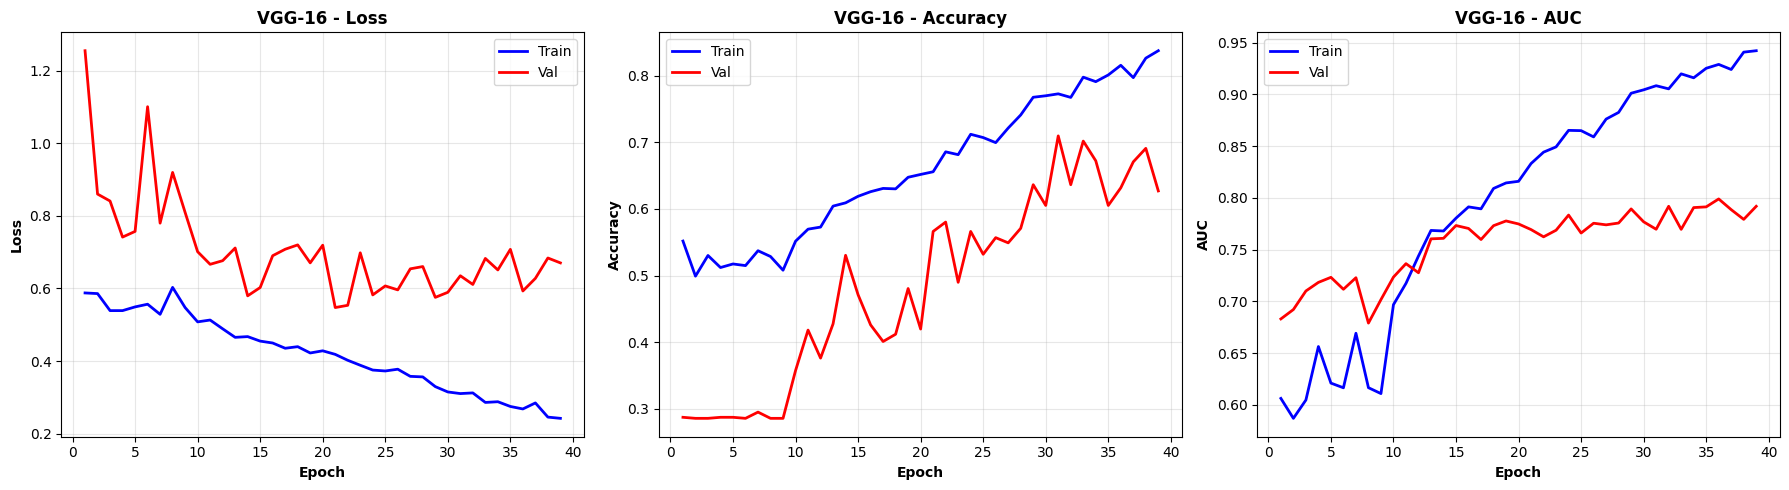


VGG-16 - Test Results
Accuracy: 0.7388
AUC: 0.7831
Sensitivity: 0.6245
Specificity: 0.7781
Male AUC: 0.7886 (n=1034)
Female AUC: 0.7769 (n=880)

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.86      0.78      0.82      1424
     Class_1       0.49      0.62      0.55       490

    accuracy                           0.74      1914
   macro avg       0.67      0.70      0.68      1914
weighted avg       0.76      0.74      0.75      1914


################################################################################
# Training ResNet-50
################################################################################



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Epoch 10: Train Loss=0.2912, Acc=0.8155, AUC=0.9219 | Val Loss=0.6310, Acc=0.6958, AUC=0.7710 | No improve: 2


Early stopping triggered at epoch 16
Best validation accuracy: 0.7878


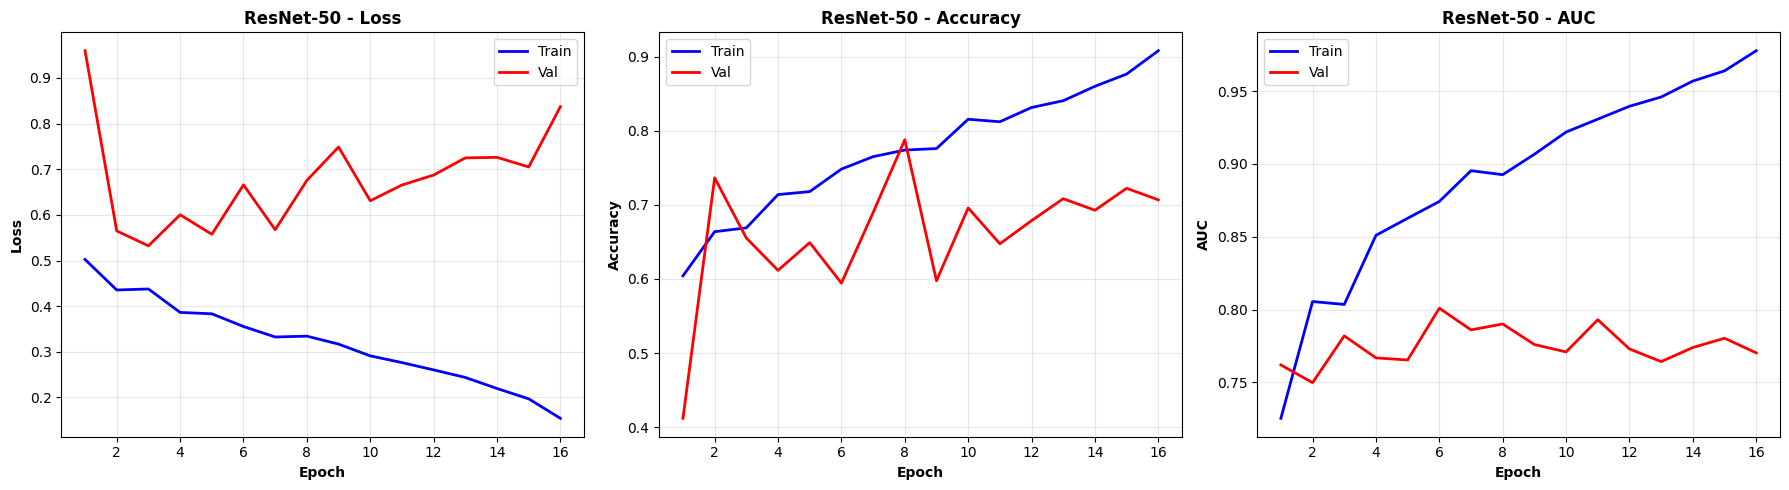


ResNet-50 - Test Results
Accuracy: 0.7900
AUC: 0.7929
Sensitivity: 0.4204
Specificity: 0.9171
Male AUC: 0.7948 (n=1034)
Female AUC: 0.7916 (n=880)

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.82      0.92      0.87      1424
     Class_1       0.64      0.42      0.51       490

    accuracy                           0.79      1914
   macro avg       0.73      0.67      0.69      1914
weighted avg       0.77      0.79      0.77      1914


################################################################################
# Training DenseNet-121
################################################################################



Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 162MB/s]


Epoch 10: Train Loss=0.1822, Acc=0.8901, AUC=0.9695 | Val Loss=0.6696, Acc=0.7426, AUC=0.8036 | No improve: 0


Epoch 20: Train Loss=0.0887, Acc=0.9567, AUC=0.9921 | Val Loss=0.9170, Acc=0.7660, AUC=0.7935 | No improve: 3


Early stopping triggered at epoch 25
Best validation accuracy: 0.7785


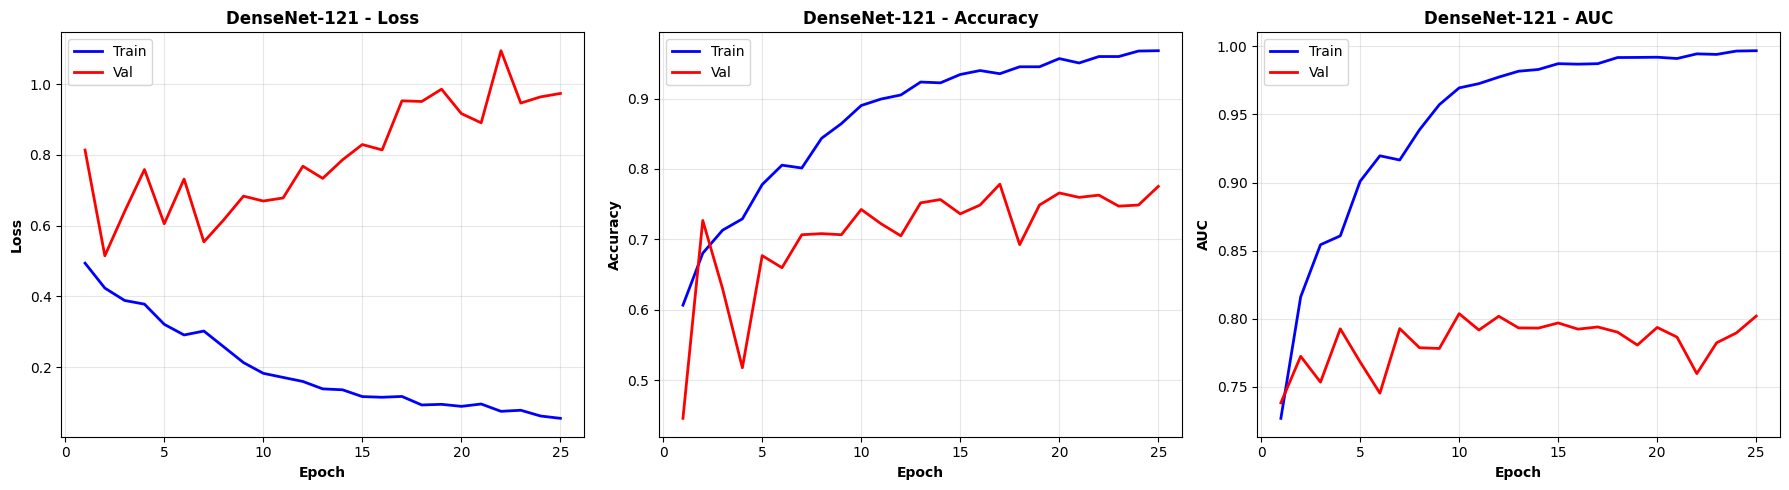


DenseNet-121 - Test Results
Accuracy: 0.7727
AUC: 0.7853
Sensitivity: 0.4878
Specificity: 0.8708
Male AUC: 0.7845 (n=1034)
Female AUC: 0.7862 (n=880)

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.83      0.87      0.85      1424
     Class_1       0.57      0.49      0.52       490

    accuracy                           0.77      1914
   macro avg       0.70      0.68      0.69      1914
weighted avg       0.76      0.77      0.77      1914


################################################################################
# Training EfficientNet-B0
################################################################################



model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 10: Train Loss=0.1996, Acc=0.8881, AUC=0.9642 | Val Loss=0.9307, Acc=0.6802, AUC=0.7130 | No improve: 0


Epoch 20: Train Loss=0.1035, Acc=0.9475, AUC=0.9905 | Val Loss=1.2258, Acc=0.7051, AUC=0.7317 | No improve: 2


Epoch 30: Train Loss=0.0432, Acc=0.9783, AUC=0.9984 | Val Loss=1.4154, Acc=0.7504, AUC=0.7489 | No improve: 0


Early stopping triggered at epoch 38
Best validation accuracy: 0.7504


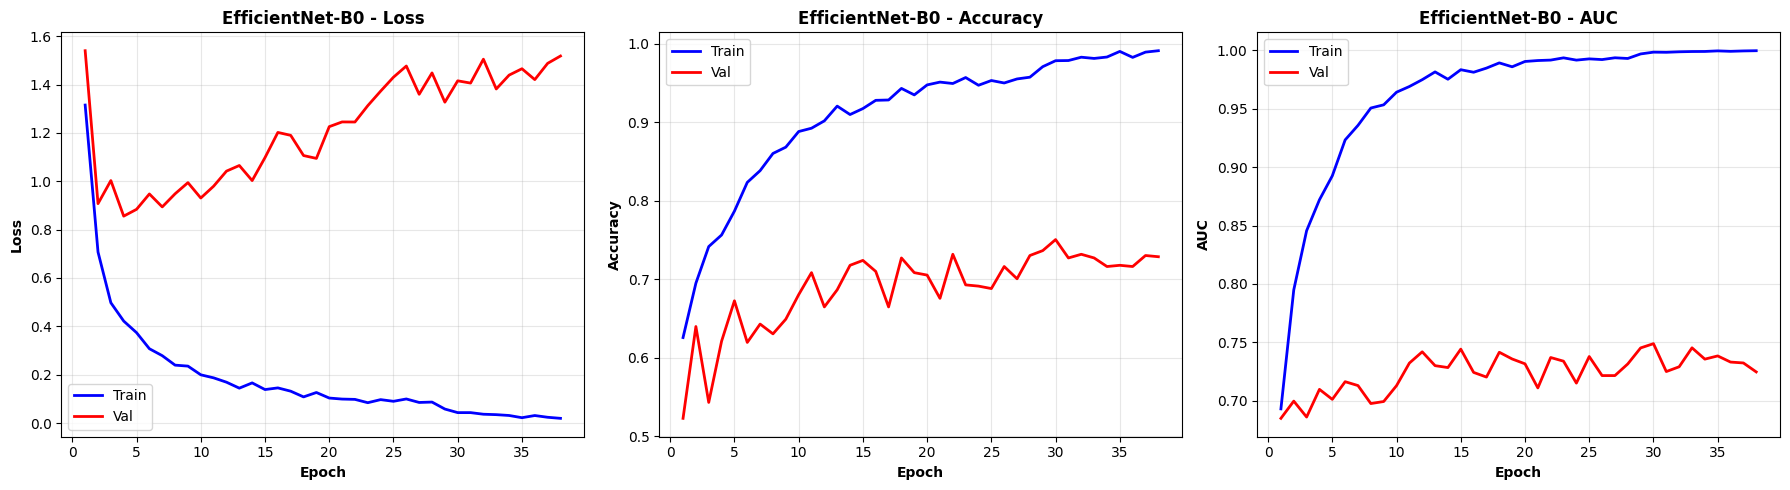


EfficientNet-B0 - Test Results
Accuracy: 0.7518
AUC: 0.7559
Sensitivity: 0.4694
Specificity: 0.8490
Male AUC: 0.7693 (n=1034)
Female AUC: 0.7412 (n=880)

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.82      0.85      0.84      1424
     Class_1       0.52      0.47      0.49       490

    accuracy                           0.75      1914
   macro avg       0.67      0.66      0.66      1914
weighted avg       0.74      0.75      0.75      1914


################################################################################
# Training ViT-Tiny
################################################################################



model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 10: Train Loss=0.3796, Acc=0.7167, AUC=0.8548 | Val Loss=0.6979, Acc=0.6303, AUC=0.7255 | No improve: 0


Epoch 20: Train Loss=0.2144, Acc=0.8595, AUC=0.9540 | Val Loss=0.8988, Acc=0.6615, AUC=0.7256 | No improve: 2


Epoch 30: Train Loss=0.1158, Acc=0.9316, AUC=0.9868 | Val Loss=1.1869, Acc=0.7161, AUC=0.7233 | No improve: 0


Epoch 40: Train Loss=0.0815, Acc=0.9549, AUC=0.9933 | Val Loss=1.3952, Acc=0.7285, AUC=0.7232 | No improve: 0


Early stopping triggered at epoch 48
Best validation accuracy: 0.7285


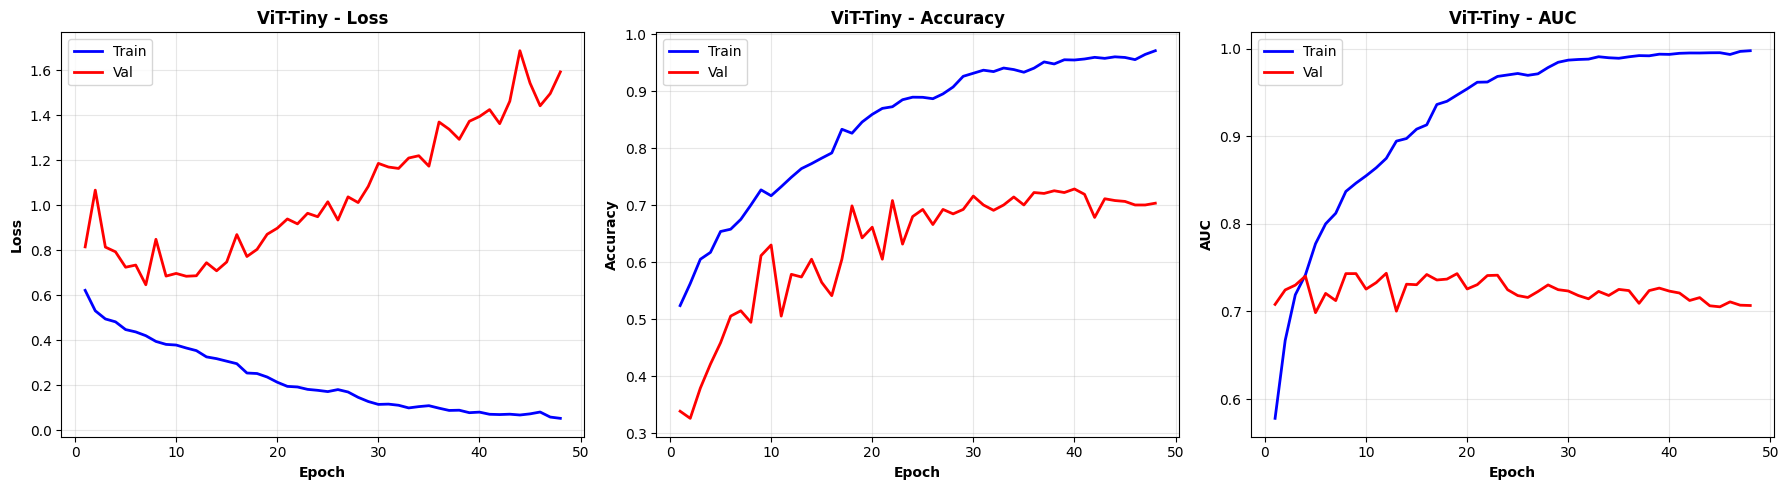


ViT-Tiny - Test Results
Accuracy: 0.7351
AUC: 0.7446
Sensitivity: 0.5612
Specificity: 0.7949
Male AUC: 0.7454 (n=1034)
Female AUC: 0.7432 (n=880)

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.84      0.79      0.82      1424
     Class_1       0.49      0.56      0.52       490

    accuracy                           0.74      1914
   macro avg       0.66      0.68      0.67      1914
weighted avg       0.75      0.74      0.74      1914



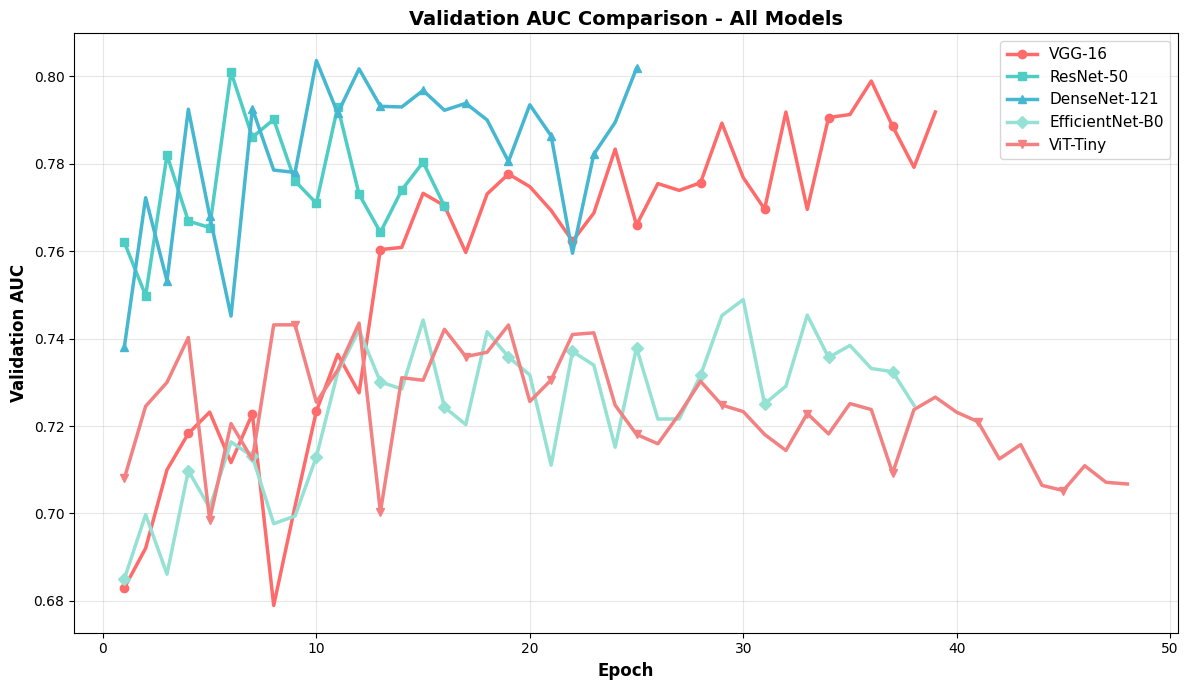

All models validation AUC comparison plot saved

FINAL COMPARISON TABLE

          Model  Accuracy    AUC  Sensitivity  Specificity  Male AUC  Female AUC
      ResNet-50    0.7900 0.7929       0.4204       0.9171    0.7948      0.7916
   DenseNet-121    0.7727 0.7853       0.4878       0.8708    0.7845      0.7862
         VGG-16    0.7388 0.7831       0.6245       0.7781    0.7886      0.7769
EfficientNet-B0    0.7518 0.7559       0.4694       0.8490    0.7693      0.7412
       ViT-Tiny    0.7351 0.7446       0.5612       0.7949    0.7454      0.7432


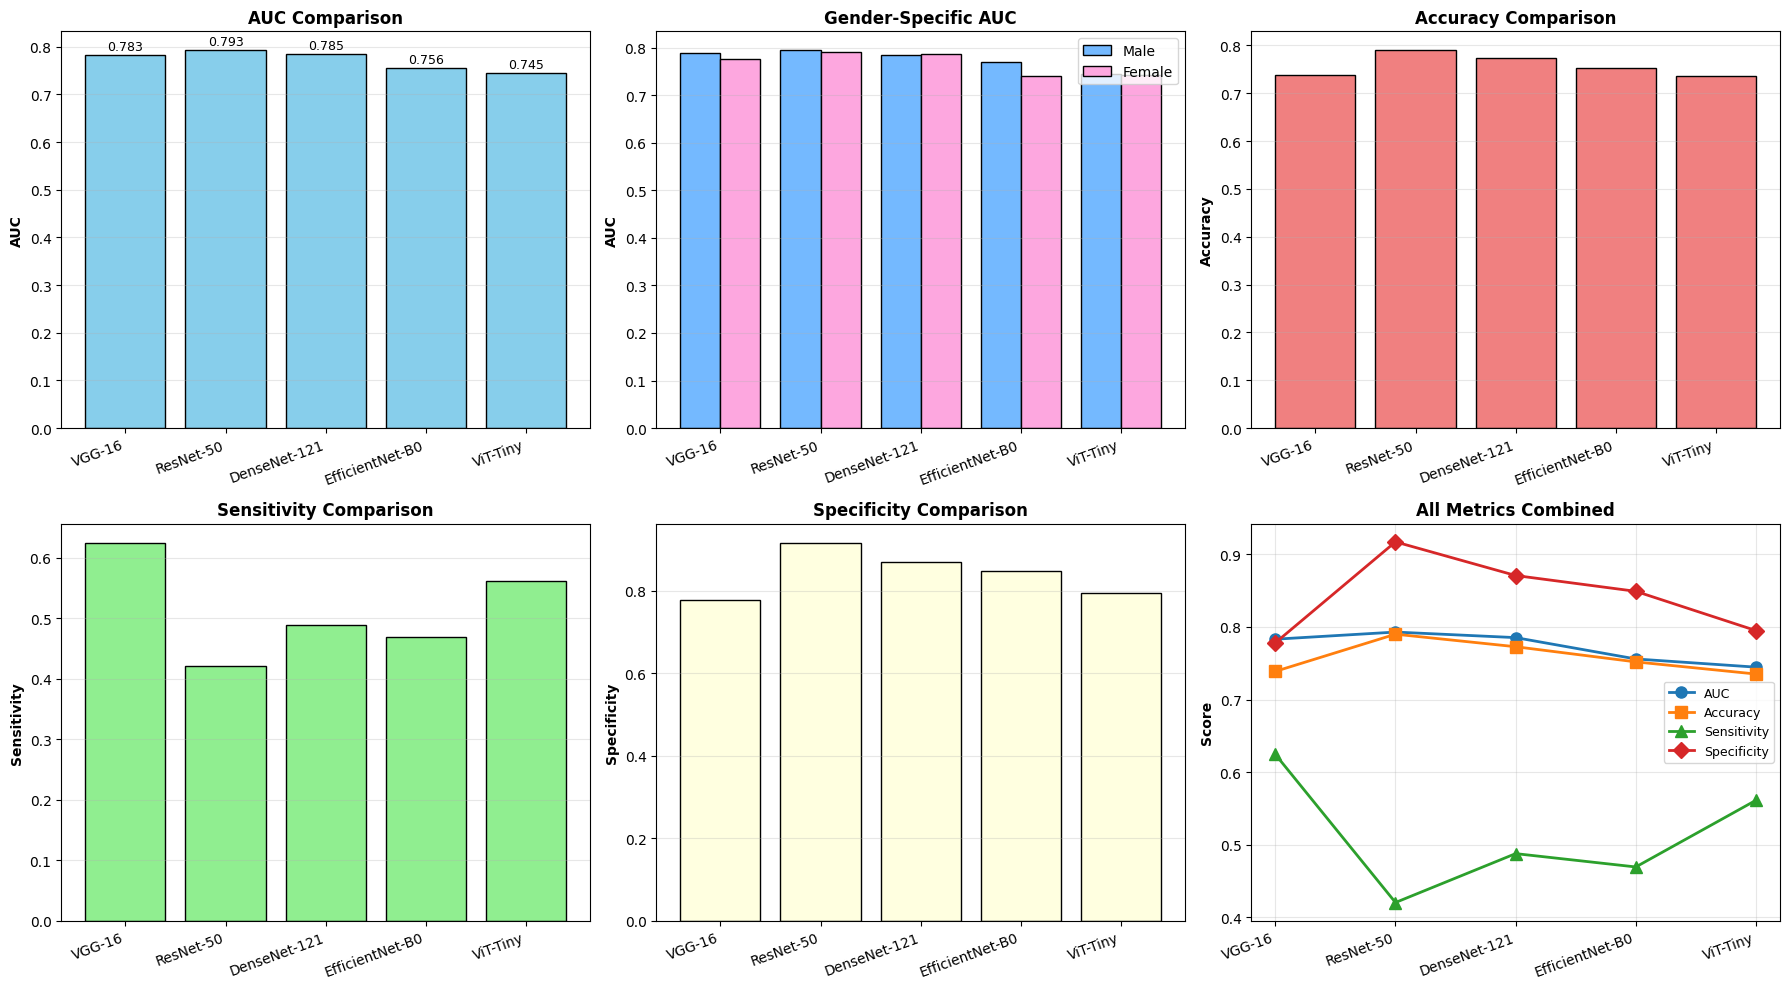

Final comparison plots saved

 Training completed successfully!


In [ ]:
if __name__ == "__main__":
    main()